# 문서 벡터를 이용한 도서 추천 시스템

In [1]:
!wget -c https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz

--2021-09-03 07:03:55--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.24.38
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.24.38|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  32.5MB/s    in 23s     

2021-09-03 07:04:18 (68.5 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [2]:
!gzip -d GoogleNews-vectors-negative300.bin.gz

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from PIL import Image

In [4]:
from google.colab import files
uploaded = files.upload()
filename = list(uploaded.keys())[0]

Saving books.csv to books.csv


In [5]:
df = pd.read_csv(filename)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2382 entries, 0 to 2381
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    2382 non-null   int64  
 1   Desc          2382 non-null   object 
 2   Unnamed: 0.1  1185 non-null   float64
 3   author        2382 non-null   object 
 4   genre         2382 non-null   object 
 5   image_link    2382 non-null   object 
 6   rating        2382 non-null   float64
 7   title         2382 non-null   object 
dtypes: float64(2), int64(1), object(5)
memory usage: 149.0+ KB


In [7]:
del df['Unnamed: 0']
del df['Unnamed: 0.1']
df.head()

,Desc,author,genre,image_link,rating,title
0,We know that power is shifting: From West to E...,Moisés Naím,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.63,The End of Power: From Boardrooms to Battlefie...
1,Following the success of The Accidental Billio...,Blake J. Harris,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.94,"Console Wars: Sega, Nintendo, and the Battle t..."
2,How to tap the power of social software and ne...,Chris Brogan,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.78,Trust Agents: Using the Web to Build Influence...
3,William J. Bernstein is an American financial ...,William J. Bernstein,Business,https://i.gr-assets.com/images/S/compressed.ph...,4.20,The Four Pillars of Investing
4,Amazing book. And I joined Steve Jobs and many...,Akio Morita,Business,https://i.gr-assets.com/images/S/compressed.ph...,4.05,Made in Japan: Akio Morita and Sony


## 데이터 전처리

In [10]:
def remove_non_ascii(s):
    return "".join(i for i in s if ord(i)<128)

In [11]:
def make_lower_case(text):
    return text.lower()

In [15]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [13]:
def remove_stop_words(text):
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

In [14]:
def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

In [18]:
from nltk.tokenize import RegexpTokenizer

In [16]:
def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'[a-zA-Z]+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

In [19]:
df['cleaned'] = df.Desc.apply(remove_non_ascii)
df['cleaned'] = df.cleaned.apply(make_lower_case)
df['cleaned'] = df.cleaned.apply(remove_stop_words)
df['cleaned'] = df.cleaned.apply(remove_punctuation)
df['cleaned'] = df.cleaned.apply(remove_html)

In [20]:
df.head()['cleaned']

0    know power shifting west east north south pres...
1    following success accidental billionaires mone...
2    tap power social software networks build busin...
3    william j bernstein american financial theoris...
4    amazing book joined steve jobs many akio morit...
Name: cleaned, dtype: object

In [22]:
# 빈 값이 생긴 행 - 삭제
df['cleaned'].replace('', np.nan, inplace=True)
df.dropna(inplace=True)

In [23]:
df.shape

(2381, 7)

In [24]:
# 토큰화
corpus = [words.split() for words in df.cleaned]

## 사전 훈련된 워드 임베딩 사용

In [26]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [27]:
word2vec_model = Word2Vec(size=300, window=5, min_count=2, workers=-1)
word2vec_model.build_vocab(corpus)
word2vec_model.intersect_word2vec_format('GoogleNews-vectors-negative300.bin', lockf=1.0, binary=True)
word2vec_model.train(corpus, total_examples=word2vec_model.corpus_count, epochs = 15)

(0, 0)

## 단어 벡터의 평균 구하기

In [29]:
def vectors(document_list):
    document_embedding_list = []

    # 각 문서에 대해서
    for line in document_list:
        doc2vec = None
        count = 0
        for word in line.split():
            if word in word2vec_model.wv.vocab:
                count += 1
                # 해당 문서에 있는 모든 단어들의 벡터값을 더한다.
                if doc2vec is None:
                    doc2vec = word2vec_model[word]
                else:
                    doc2vec = doc2vec + word2vec_model[word]

        if doc2vec is not None:
            # 단어 벡터를 모두 더한 벡터의 값을 문서 길이로 나눠준다.
            doc2vec = doc2vec / count
            document_embedding_list.append(doc2vec)

    # 각 문서에 대한 문서 벡터 리스트를 리턴
    return document_embedding_list

In [31]:
import warnings
warnings.filterwarnings('ignore')

In [32]:
document_embedding_list = vectors(df['cleaned'])
print('문서 벡터의 수 :', len(document_embedding_list))

문서 벡터의 수 : 2381


## 추천 시스템 구현

In [28]:
from sklearn.metrics.pairwise import cosine_similarity

In [33]:
cosine_similarities = cosine_similarity(document_embedding_list, document_embedding_list)
print('코사인 유사도 매트릭스의 크기 :', cosine_similarities.shape)

코사인 유사도 매트릭스의 크기 : (2381, 2381)


In [41]:
import requests
from io import BytesIO

def recommendations(title):
    books = df[['title', 'image_link']]

    # 책의 제목을 입력하면 해당 제목의 인덱스를 리턴받아 idx에 저장.
    indices = pd.Series(df.index, index=df.title).drop_duplicates()    
    idx = indices[title]

    # 입력된 책과 줄거리(document embedding)가 유사한 책 5개 선정.
    sim_scores = list(enumerate(cosine_similarities[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:6]

    # 가장 유사한 책 5권의 인덱스
    book_indices = [i[0] for i in sim_scores]

    # 전체 데이터프레임에서 해당 인덱스의 행만 추출. 5개의 행을 가진다.
    recommend = books.iloc[book_indices].reset_index(drop=True)

    fig = plt.figure(figsize=(20, 30))

    # 데이터프레임으로부터 순차적으로 이미지를 출력
    for index, row in recommend.iterrows():
        response = requests.get(row['image_link'])
        img = Image.open(BytesIO(response.content))
        fig.add_subplot(1, 5, index + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(row['title'])

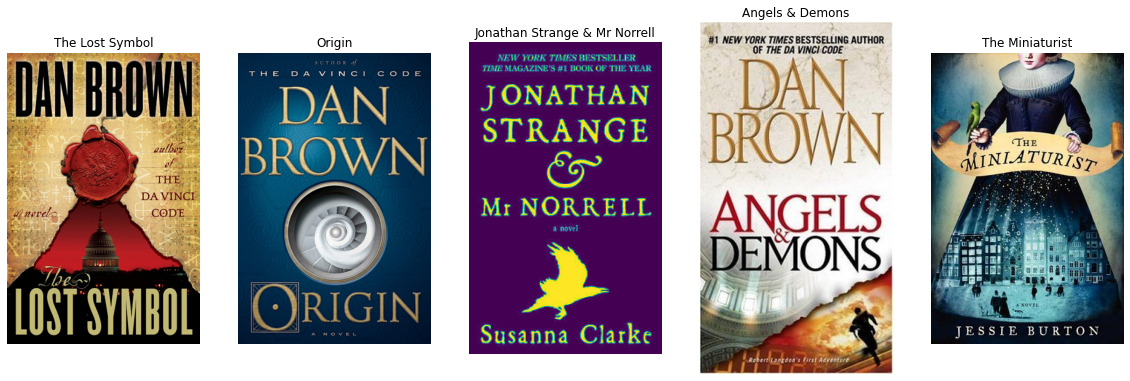

In [42]:
recommendations("The Da Vinci Code")

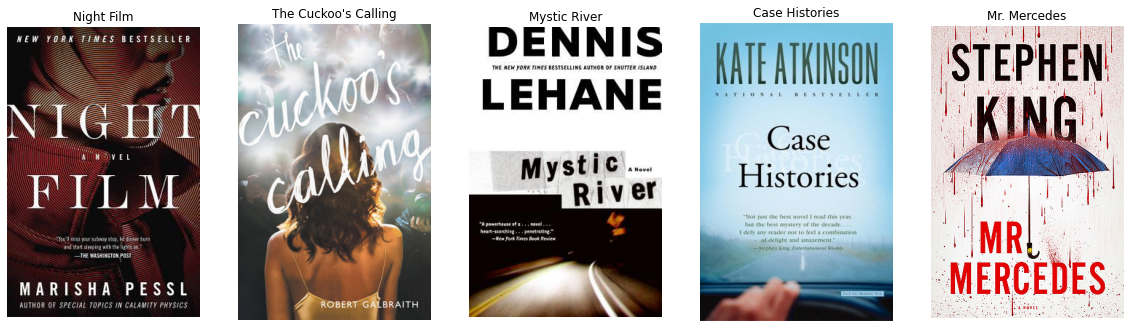

In [43]:
recommendations("The Murder of Roger Ackroyd")